In [1]:
import os, sys, json, copy, random, pickle, time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# set to my fork with fix on server
# sys.path.insert(0, '../../../myfastai')
# set to dev-head on local
sys.path.insert(0, '../../../fastaif')
import fastai
print(fastai.__version__)

from fastai.vision import *
from fastai.utils.mem import  gpu_mem_get_free_no_cache

%reload_ext autoreload
%autoreload 2

from modules.ap3data import build_data
from modules.ap3graph import pred_cmp_viz

from modules.miscutils import ( scp_from_gcloud
                               ,move_file_obj
                               ,fastai_version
                              )
from modules.modeleval import ( calc_sse
                               ,calc_mse
                               ,err_to_np
                               ,ModelHome
                               ,Residuals
                              )

1.0.53.dev0


In [2]:
# the two datasets for apfit2-X models

data_small = build_data(batch_size=16, 
                        size=(216, 324), 
                        valid_pct=0.2,
                        )
data_large = build_data(batch_size=16, 
                        size=(288, 432), 
                        valid_pct=0.2,
                        )

all validations pass
all validations pass


In [3]:
m1 = ModelHome(
                model_arch=models.resnet50,
                dataset=data_large,
                pth_fn='new-models/apfit2-1.pth',
                name='apfit2-1',
                history_fn='new-models/apfit2-1.csv',
                preds_fn='misc-data/preds-apfit2-1.pickle',
                )

In [4]:
m1.get_prediction(0)

tensor([ 0.0061, -0.0993,  0.0151,  0.0378,  0.3364,  0.0322,  0.3136, -0.1120])

In [5]:
m1.get_truth(0)

tensor([[ 0.0023, -0.1065],
        [-0.0185,  0.0648],
        [ 0.3241,  0.0679],
        [ 0.3218, -0.1034]])

In [6]:
m1.build_avg_pred_time()

avg pred time (ms): 530  [min: 521 | max: 538]


In [4]:
m4 = ModelHome(
                model_arch=models.resnet34,
                dataset=data_small,
                pth_fn='new-models/apfit2-4.pth',
                name='apfit2-4',
                history_fn='new-models/apfit2-4.csv',
                preds_fn='misc-data/preds-apfit2-4.pickle',
                )

In [29]:
m4.get_prediction(0)

tensor([ 0.0198, -0.0476,  0.0118, -0.0748,  0.3744, -0.0899,  0.3691, -0.0659])

In [30]:
m4.get_truth(0)

tensor([[ 0.0023, -0.1065],
        [-0.0185,  0.0648],
        [ 0.3241,  0.0679],
        [ 0.3218, -0.1034]])

In [37]:
# figure out get_truth(b_train=True)
ret = m4.dataset.train_dl.y.items[0]
print(ret)
from modules.ap3graph import get_ip
x = get_ip(m1.dataset.train_dl.get(0), ret)  #img-should be half
x.data

tensor([[253., 432.],
        [264., 698.],
        [525., 696.],
        [528., 428.]])


tensor([[-0.4144, -0.3333],
        [-0.3889,  0.0772],
        [ 0.2153,  0.0741],
        [ 0.2222, -0.3395]])

In [31]:
m4.build_avg_pred_time()

avg pred time (ms): 199  [min: 175 | max: 218]


In [18]:
m1.valid_err, m4.valid_err

(tensor(0.0103), tensor(0.0146))

##### Use pred_cmp_viz

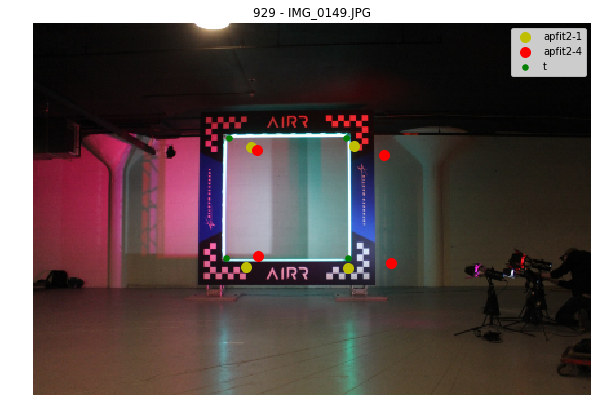

In [27]:
# compare on training set
pred_cmp_viz([m1, m4], add_truth = True, legend=True, i=None )
# 0 - good
# 1110 - bad miss for good model
# 1008 - bad miss for both
# 649 - bad miss both
# 390 - bad miss both
# 755 - worst model regression from bad-model to good-model
# are there any good ones??
# 70 is decent
# 919 - decent for both
# 558
# 216 - excellent for both

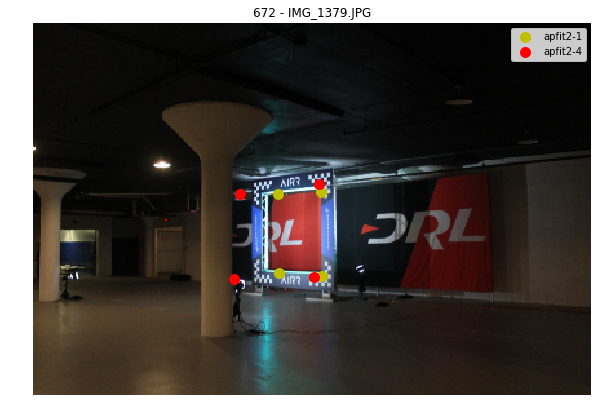

In [17]:
#trainers
pred_cmp_viz([m1, m4], add_truth = False, legend=True, b_train=True)
#390 - good
#672 - decent

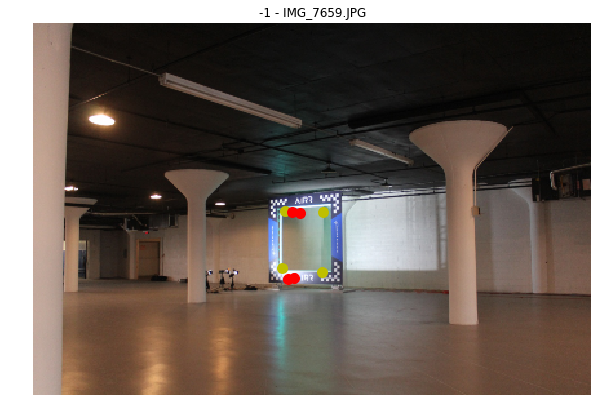

In [24]:
# pass-in prediction inputs
img0 = m1.dataset.valid_dl.get(0)
fn0 = m1.dataset.valid_dl.items[0]
preds = [m1.model.predict(img0)[2], m4.model.predict(img0)[2]]

pred_cmp_viz(list_mh=None,i=-1,list_preds=preds,preds_input=(fn0,img0))

##### Figure out ImagePoint transforms

In [101]:
from modules.ap3graph import scaled_pts
from modules.ap3graph import pts_transform, get_ip

In [110]:
#replicate pred_compare transform
pred0 = m1.model.predict(m1.dataset.valid_dl.get(0))
print(pred0[0].data)
scaled_pred0 = scaled_pts(pred0[0])
print(scaled_pred0)
flip_pred0 = tensor([[e[1],e[0]] for e in list(scaled_pred0)])
print(flip_pred0)
ip_pred0 = get_ip(img1, flip_pred0)
print(ip_pred0)
print(ip_pred0.data)

tensor([[ 0.0061, -0.0993],
        [ 0.0151,  0.0378],
        [ 0.3364,  0.0322],
        [ 0.3136, -0.1120]])
tensor([[583.6802, 434.6361],
        [672.4882, 438.5437],
        [668.8354, 577.3103],
        [575.4006, 567.4644]])
tensor([[434.6361, 583.6802],
        [438.5437, 672.4882],
        [577.3103, 668.8354],
        [567.4644, 575.4006]])
ImagePoints (864, 1296)
tensor([[ 0.0061, -0.0993],
        [ 0.0151,  0.0378],
        [ 0.3364,  0.0322],
        [ 0.3136, -0.1120]])


In [117]:
#now replicate from flat preds
pred0 = m1.preds[0][0]
print(pred0)
reshape_pred0 = pred0.reshape([4,2])
print(reshape_pred0)
ip_pred0 = ImagePoints(FlowField(img1.size, reshape_pred0))
print(ip_pred0)
print(ip_pred0.data)

ip2_pred0 = get_ip(img1, reshape_pred0)
print(ip2_pred0.data)

ip3_pred0 = ImagePoints(FlowField(img1.size, reshape_pred0), scale=False)
print(ip3_pred0)
print(ip3_pred0.data)

tensor([ 0.0061, -0.0993,  0.0151,  0.0378,  0.3364,  0.0322,  0.3136, -0.1120])
tensor([[ 0.0061, -0.0993],
        [ 0.0151,  0.0378],
        [ 0.3364,  0.0322],
        [ 0.3136, -0.1120]])
ImagePoints (864, 1296)
tensor([[-1.0000, -1.0002],
        [-1.0000, -0.9999],
        [-0.9992, -1.0000],
        [-0.9993, -1.0002]])
tensor([[-1.0000, -1.0002],
        [-1.0000, -0.9999],
        [-0.9992, -1.0000],
        [-0.9993, -1.0002]])
ImagePoints (864, 1296)
tensor([[ 0.0061, -0.0993],
        [ 0.0151,  0.0378],
        [ 0.3364,  0.0322],
        [ 0.3136, -0.1120]])
